In [1]:
import numpy as np
import pandas as pd
import sympy as sympy

import seaborn as sns
import matplotlib.pyplot as plt

from SCR_Benchmarks.Constants import StringKeys as sk
import SCR_Benchmarks.SRSDFeynman as srsdf
from SCR_Benchmarks import SCRBenchmark

ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

benchmark data can be generated as a 2D numpy array. 
The last column contains the target values.

Alternatively, it can be created as a pandas DataFrame where the columns are named using the readable display name of variables, so `theta` instead of `x0`.

Both methods are interchangeable, as proven by the following example with a fixed random seed

In [2]:
ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

np.random.seed(0)
(training, test) = ICh6Eq20.create_dataset(sample_size=1000, patience= 10, train_test_split = 0.8)
np.random.seed(0)
(training_df, test_df) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10,  train_test_split = 0.8)

train_df_to_np = training_df.to_numpy()

print((training==train_df_to_np).all())

True


The train-test-split determines the ration between training and test size.
A `train_test_split=1` results in only training data.
A `train_test_split=0` results in only test data.

However, the train-test-split provides testing data to determine the model's extrapolation behavior.
The following example shows that we continuosly take from the convex hull of the data to provide extrapolation data for the test-set.

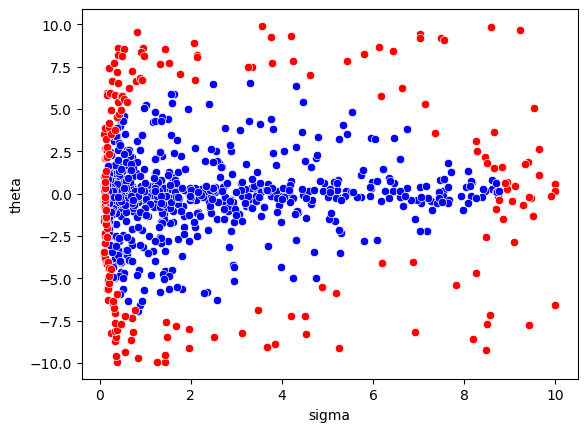

In [7]:
fig = sns.scatterplot(x='sigma', y='theta', data=training_df, c = 'b')
fig = sns.scatterplot(ax = fig, x='sigma', y='theta', data=test_df, c = 'r')